In [1]:
from autoencoder import *

In [2]:
theta = np.linspace(-np.pi,0.0*np.pi,500, dtype=np.float32)
data = np.vstack([np.cos(theta), np.sin(theta)]).T
dataset = tf.data.Dataset.from_tensor_slices(data)

In [3]:
graph = tf.Graph()
with graph.as_default():
    tr_x = atu.make_datastream(dataset)
    au = PolyAutoencoder(2,1,tr_x, 5,5)
    init=tf.global_variables_initializer()

In [4]:
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(graph=graph)
init.run(session=sess)

In [5]:
for i in xrange(10000):
    #train_step.run(session=sess)
    sess.run(au.train_step)
    if i%1000==99:
        print au.goal.eval(session=sess)

2.23269
0.006012429
0.0049699894
0.0055207787
0.0016345578
0.024498846
0.0019841644
0.00035247856
0.001411232
0.000680387


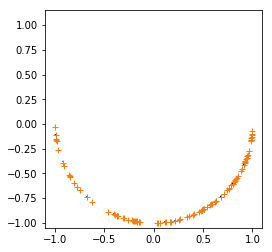

In [6]:
au.plot_distance()

In [7]:
with graph.as_default():
    # The mass matrix
    momentum = tf.constant(0.5)*tf.reduce_sum( tf.pow( au.o_x , 2 ) )
    o_M = tf.hessians( momentum, au.i_q )[0]
    o_U = au.o_x[:,1]
    o_gradU = tf.gradients( o_U, au.i_q)[0]
    o_gradX = tf.gradients(au.o_x, au.i_q)[0]

In [8]:
import afqsrungekutta as ark

In [ ]:
class tfrk(ark.RK_field_numpy):
    def sys(self,time,tang=False):
                if tang:
                    return [np.array([-k*u[0]],np.double), np.array([[-k]],np.double)]
                else:
                    return np.array([-k*u[0]],np.double)